# Predicting Term Deposit Subscriptions: A Data Science Approach

## 1. Introduction 

### Introduction

In this notebook, we delve into the Bank Marketing Data Set, a rich dataset that encapsulates the results of direct marketing campaigns conducted by a Portuguese bank. These campaigns, primarily conducted through phone calls, aimed to determine whether clients would subscribe to a term deposit. Our analysis focuses on applying logistic regression to predict the outcome of these marketing efforts, aiming to discern patterns that influence a client's decision to subscribe.

The dataset, created by Paulo Cortez (Univ. Minho) and Sérgio Moro (ISCTE-IUL) and discussed in their 2011 publication, offers a comprehensive view of customer interactions over the span from May 2008 to November 2010. It features a variety of input variables from client data, such as age and job type, to more specific ones related to the marketing campaign itself, like the contact type and last contact duration.

### Project Goal

The primary goal of this project is to predict whether a bank client will subscribe to a term deposit based on historical data. This binary classification problem will be tackled using logistic regression, a robust statistical method suitable for predicting the probability of occurrence of an event by fitting data to a logistic curve.

### Methodology

Our approach will encompass several key phases:
1. **Data Exploration**: We will start by exploring the dataset to understand its structure, contents, and the relationships between different variables.
2. **Data Preprocessing**: This step will include cleaning the data, handling missing values if any, and preparing the data for modeling through techniques such as feature encoding and scaling.
3. **Modeling with Logistic Regression**: We will build a logistic regression model to predict the likelihood of a client subscribing to a term deposit.
4. **Model Evaluation**: The model's performance will be evaluated using appropriate metrics such as accuracy, precision, recall, and the ROC curve to assess its effectiveness in predicting the target variable.

By following these steps, we aim to provide actionable insights that could potentially enhance the efficiency of the bank’s marketing strategies.


### Bank Client Data Features
- **age**: Numeric. The age of the client.
- **job**: Categorical. The type of job the client holds (e.g., "admin", "technician", "services", "management", etc.).
- **marital**: Categorical. Marital status of the client (e.g., "married", "single", "divorced").
- **education**: Categorical. Education level of the client (e.g., "primary", "secondary", "tertiary", "unknown").
- **default**: Binary. Indicates if the client has credit in default ("yes", "no").
- **balance**: Numeric. The average yearly balance, in euros.
- **housing**: Binary. Indicates if the client has a housing loan ("yes", "no").
- **loan**: Binary. Indicates if the client has a personal loan ("yes", "no").
- **contact**: Categorical. Type of contact communication (e.g., "cellular", "telephone", "unknown").
- **day**: Numeric. Last contact day of the month.
- **month**: Categorical. Last contact month of the year (e.g., "jan", "feb", "mar", ..., "nov", "dec").
- **duration**: Numeric. Last contact duration, in seconds.
- **campaign**: Numeric. Number of contacts performed during this campaign for this client.
- **pdays**: Numeric. Number of days that passed by after the client was last contacted from a previous campaign; -1 means client was not previously contacted.
- **previous**: Numeric. Number of contacts performed before this campaign for this client.
- **poutcome**: Categorical. Outcome of the previous marketing campaign (e.g., "unknown", "other", "failure", "success").
- **y (target variable)**: Binary. Indicates whether the client subscribed to a term deposit ("yes", "no").

## 2. Data Exploration and Understanding

### 2.1 Loading the Dataset and Relevant Libraries


In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and transformation
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE


# Model selection and validation tools
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Note the import from imblearn, not sklearn
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import warnings

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer

In [2]:
# Load Data
bank_data = pd.read_csv("bank.csv", delimiter=';')

### 2.2 Initial Data Overview

In this section, we'll take a first look at the structure and characteristics of our dataset. We'll examine the first few rows, get summary statistics, check data types, and look for missing or unusual values.

In [3]:
bank_data.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


We can see some 'unknown' values present in the 'contact' and 'poutcome' columns, which suggests potential data quality issues.

In [4]:
bank_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


**Observations:**
*  The average age of clients in the dataset is about 41 years old, with the youngest being 19 and the oldest being 87.
* The average balance is around 1422, but the large standard deviation (3009) suggests a wide range of balances and potential outliers. Some clients have negative balances.
* The 'duration' column (duration of last contact) also shows a large variation.
* Most clients have not been contacted in a previous campaign (pdays mean is close to -1, which is the value for no prior contact).

In [5]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


**Observations:**
* The dataset contains a mix of numerical ('int64') and categorical ('object') features. For example, 'age' and 'balance' are numerical, while 'job' and 'marital' are categorical.
* There are no missing values reported as NaN. However, we'll need to investigate potential missing data represented as 'unknown', as seen in the previous `.head()` output.

In [6]:
# Check for any missing values in the DataFrame
missing_values = bank_data.isnull().sum()
print(missing_values)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [7]:
# Check for columns that contain 'unknown' which might be considered as missing
unknown_values = (bank_data == 'unknown').sum()
print(unknown_values)

age             0
job            38
marital         0
education     187
default         0
balance         0
housing         0
loan            0
contact      1324
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome     3705
y               0
dtype: int64


We can see that while there are no missing values in the traditional sense (NaN), several columns contain "unknown" entries.  Specifically, the 'job', 'education', 'contact', and 'poutcome' columns have a significant number of "unknown" values. These will need to be addressed during data preprocessing. We'll explore strategies to handle these "unknown" values effectively. 

### 2.3 Exploratory Data Analysis (EDA)

Now we'll perform a visual exploration of our data using histograms and bar charts to better understand the distributions of our features.

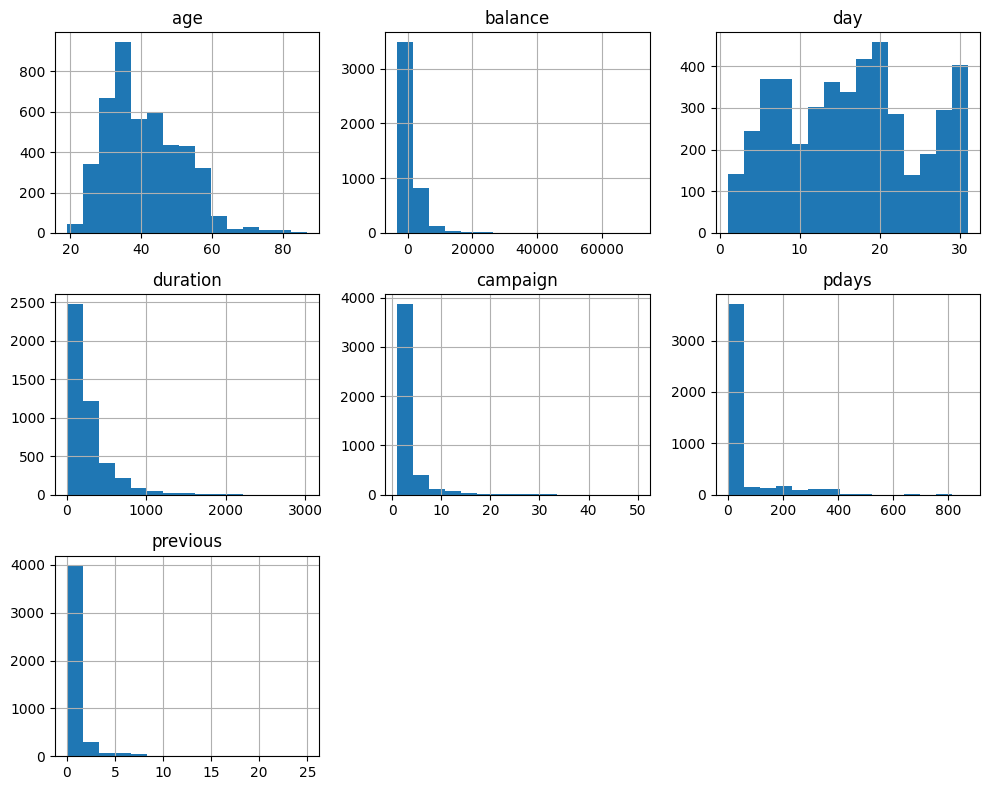

In [8]:
# Histograms for numeric features
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Generating histograms for numeric features
bank_data[numeric_features].hist(bins=15, figsize=(10, 8), layout=(3, 3))
plt.tight_layout()
plt.show()

**Observations from Histograms:** 

* **Age:** The age distribution shows a somewhat normal distribution with a peak in the younger adult range (20s-30s). 
* **Balance:** The balance histogram is heavily skewed to the right, with most customers having lower balances and a few having very high balances (potential outliers). 
* **Duration:**  Duration is also right-skewed. Most calls are relatively short, with a few lasting much longer. 
* **Campaign:**  Most clients have been contacted only a few times during this campaign.
* **Pdays:** The pdays histogram confirms that most clients were not contacted during a previous campaign (-1). There's a smaller peak around 200 days.
* **Previous:**  A majority of customers have not been contacted before (0 previous contacts).

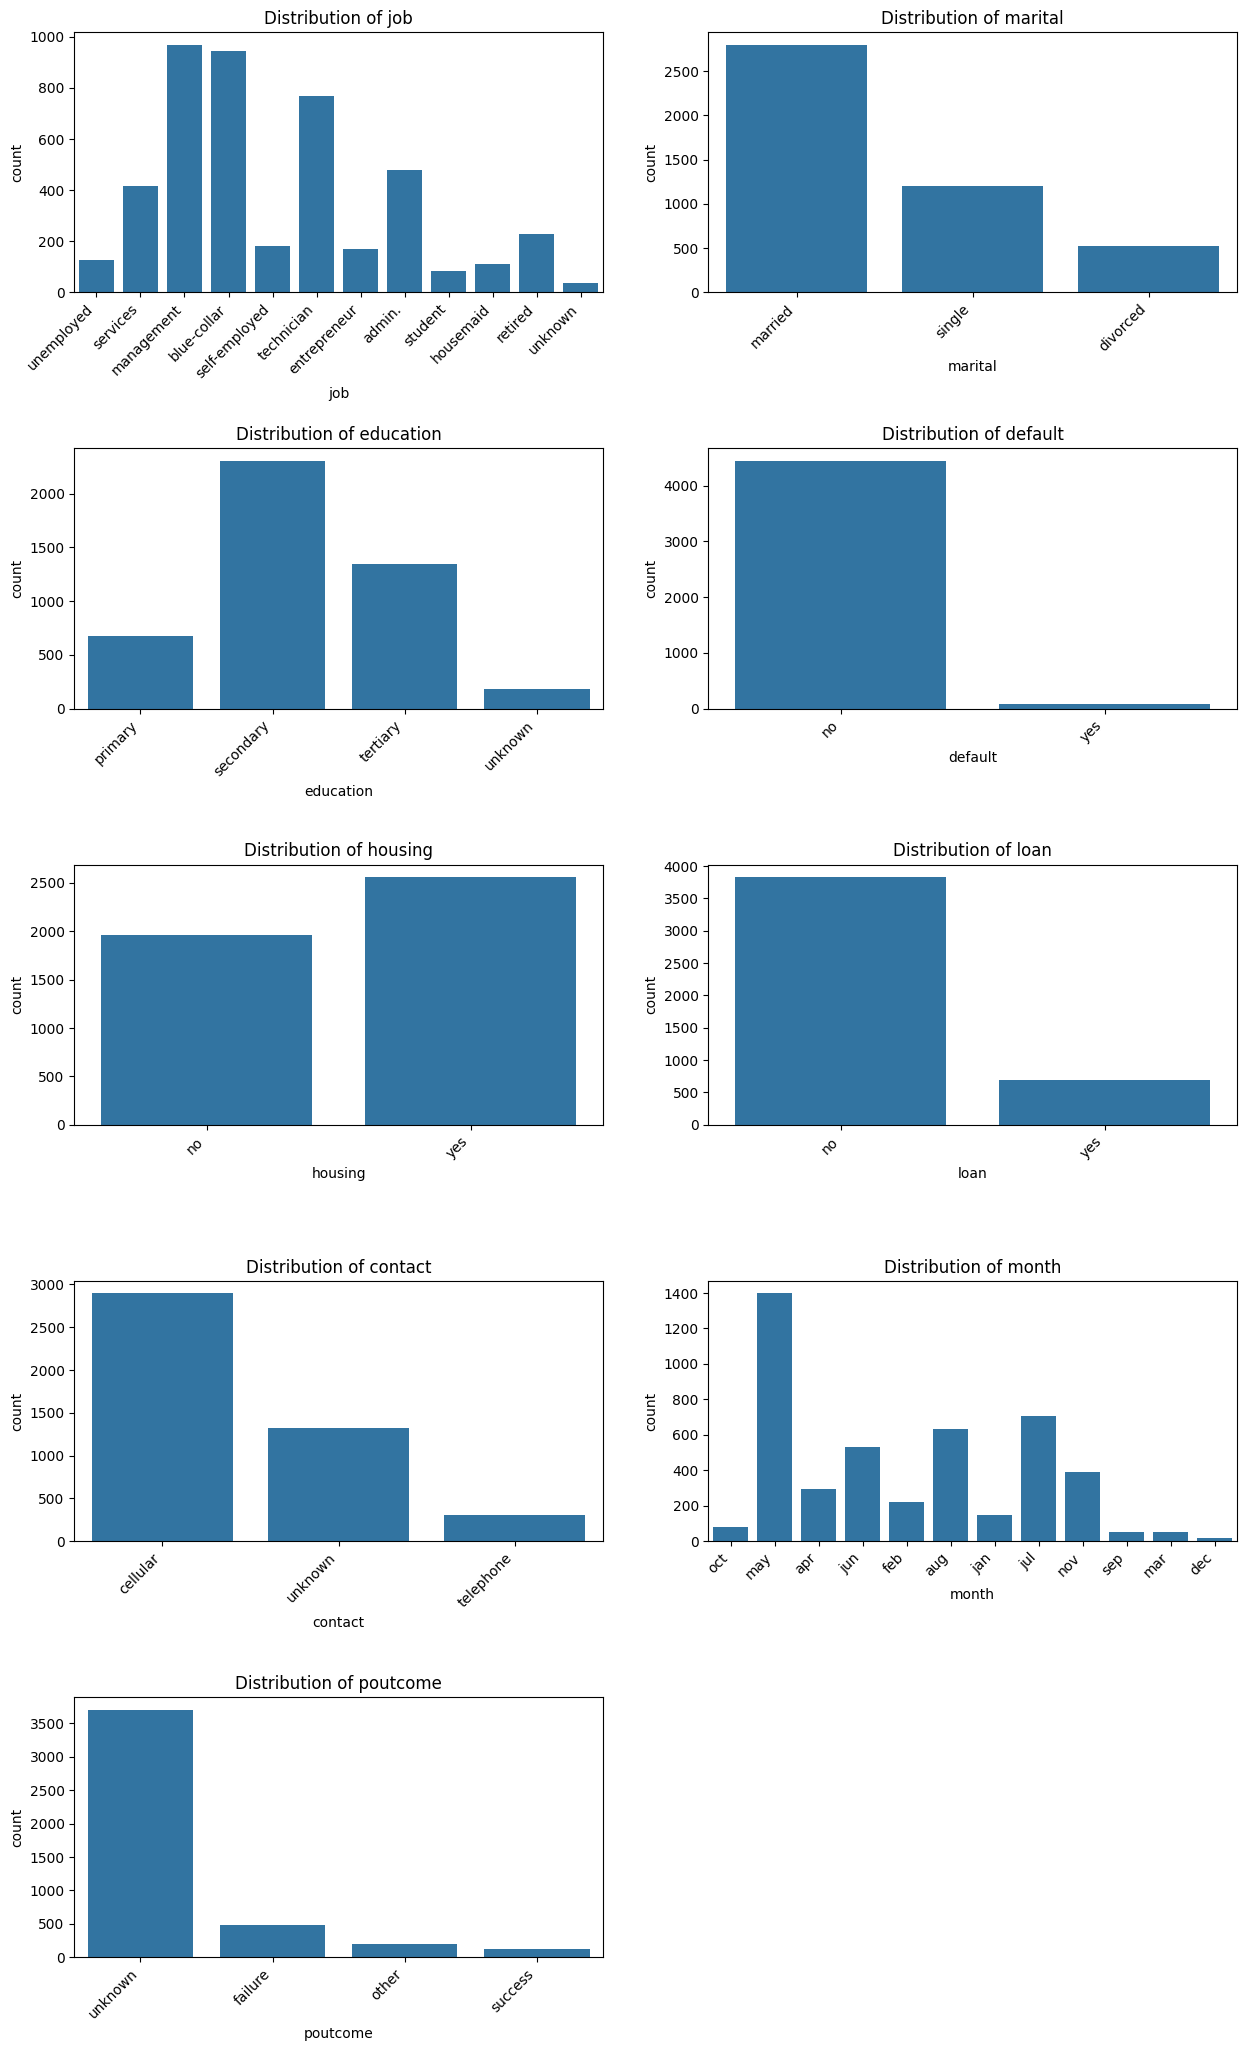

In [9]:
# Bar charts for categorical features
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Create a figure with multiple subplots arranged in a grid
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))
fig.subplots_adjust(hspace=0.6)

# Iterate over the categorical features and their corresponding axes
for feature, ax in zip(categorical_features, axes.flatten()):
    sns.countplot(x=feature, data=bank_data, ax=ax)
    ax.set_title(f'Distribution of {feature}')
    
    # Rotate tick labels *after* the plot is drawn
    plt.sca(ax) # Set the current axes 
    plt.xticks(rotation=45, ha='right')

# Hide any empty subplots if the grid is not fully populated
for i in range(len(categorical_features), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.show()

**Observations from Bar Charts:**
* **Job:**  The most common job categories are "management", "blue-collar", and "technician."
* **Marital:** Most clients are married, followed by single and divorced.
* **Education:** The majority of clients have secondary or tertiary education levels.
* **Default:** Most clients do not have credit in default.
* **Housing:** More clients have a housing loan than not.
* **Loan:**  A smaller proportion of clients have a personal loan.
* **Contact:**  "Cellular" is the most common contact communication type. There's a significant portion of "unknown" values here.
* **Month:** May is the month with the highest number of contacts, while December has the lowest.
* **Poutcome:** The "poutcome" feature has a large class imbalance. A majority of the previous campaign outcomes are "unknown." 

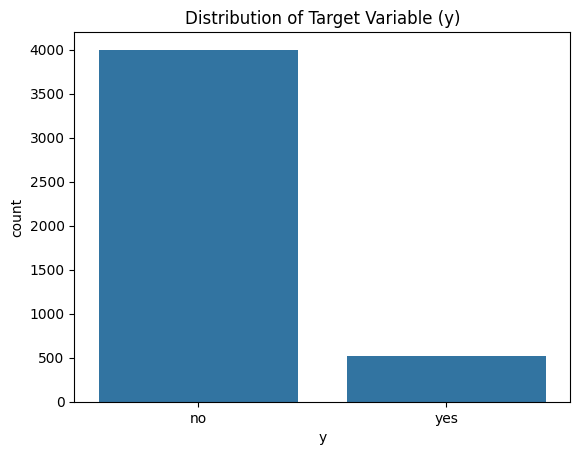

In [10]:
# Plot for the balance of the target variable
sns.countplot(x='y', data=bank_data)
plt.title('Distribution of Target Variable (y)')
plt.show()


**y (Target Variable):**  The target variable is imbalanced. There are significantly more 'no' (did not subscribe) than 'yes' (subscribed). This imbalance will be an important consideration for modeling. 

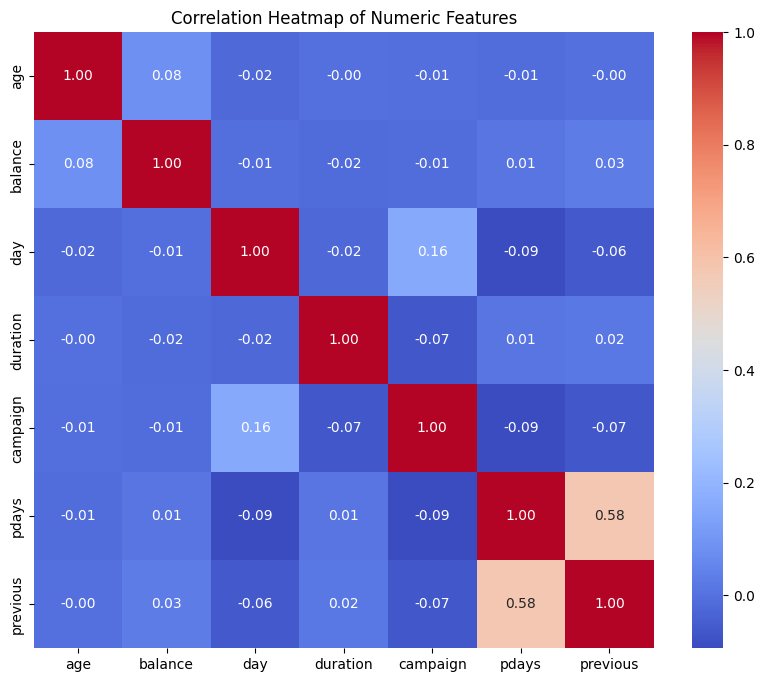

In [11]:
# Calculate correlations
correlation_matrix = bank_data[numeric_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


**Observations from the Correlation Heatmap:**

* There is a moderate positive correlation (0.58) between 'pdays' (number of days since last contact from a previous campaign) and 'previous' (number of contacts before this campaign). This makes sense, as clients contacted more recently in the past are likely to have been contacted more often.
* Other than that, there are no very strong correlations between the numerical features.

## 3. Data Preprocessing and Feature Engineerin 

In this section, we'll prepare our data for modeling. This involves splitting our data intro training and testing sets, handling missing values, engineering new features, and encoding categorical variables. 

In [12]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    bank_data.drop(columns=['duration', 'y'], axis=1),  # X (features)
    bank_data['y'],              # y (target variable)
    test_size=0.2,  # Adjust test size as needed
    random_state=4837  # Set random state for reproducibility 
)

We first split our data into training and test sets to prevent **data leakage** - a problem where information from the test set could unfairly influence our model's training. By keeping the test set separate and unseen, we ensure a more realistic evaluation of how well our model generalizes to new data. All preprocessing and feature engineering steps will be applied separately to these sets.

### 3.2 Handling Missing Values

In [13]:
# Replace 'unknown' with NaN and drop rows with NaN values
X_train = X_train.replace('unknown', np.nan).dropna()
X_test = X_test.replace('unknown', np.nan).dropna()

# Adjust the target variable 'y' accordingly
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

We identified "unknown" values as a potential data quality issue during our initial data exploration. Here, we drop those values in order to focus on clean and reliable data for our analysis. By replacing "unknown" with NaN and subsequently removing these rows, we ensure that our model is trained on data that is complete and accurate, thereby improving the robustness and validity of our predictions.

### 3.3 Feature Engineering

In [14]:
# Binning 'age'
def age_groups(age):
    if age <= 25:
        return 'Young'
    elif age <= 60:
        return 'Middle-aged'
    else:
        return 'Senior'

# Apply age_groups to training data
X_train['age_group'] = X_train['age'].apply(age_groups)
X_train = X_train.drop(columns=['age'], axis=1)

# Apply age_groups to test data
X_test['age_group'] = X_test['age'].apply(age_groups) 
X_test = X_test.drop(columns=['age'], axis=1)

We can create a new categorical feature, 'age_group', by binning the 'age' feature. This can help capture non-linear relationships with the target variable.

## 4.  Baseline Model: Dummy Classifier

Before we build a more complex model, let's establish a baseline for comparison. We'll use a Dummy Classifier that always predicts the majority class ('no' in this case). 

In [15]:
# Initialize the Dummy Classifier
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit the Dummy Classifier
dummy_clf.fit(X_train, y_train)

# Make predictions
y_dummy_pred = dummy_clf.predict(X_test)

# Evaluate the Dummy Classifier
dummy_accuracy = accuracy_score(y_test, y_dummy_pred)
print("Dummy Classifier Accuracy:", dummy_accuracy)
print(classification_report(y_test, y_dummy_pred, zero_division=0))  # Set zero_division to 0
print("Confusion Matrix:\n", confusion_matrix(y_test, y_dummy_pred))

Dummy Classifier Accuracy: 0.7612903225806451
              precision    recall  f1-score   support

          no       0.76      1.00      0.86       118
         yes       0.00      0.00      0.00        37

    accuracy                           0.76       155
   macro avg       0.38      0.50      0.43       155
weighted avg       0.58      0.76      0.66       155

Confusion Matrix:
 [[118   0]
 [ 37   0]]


The Dummy Classifier achieved an accuracy of approximately 76%. However, this is misleading since it simply predicts 'no' for every instance, taking advantage of the class imbalance. The F1-score for the 'yes' class is 0, indicating it fails to identify any positive cases. 

We'll use cross-validation to get a more robust estimate of the Dummy Classifier's performance. 

In [16]:
# Cross-validation for the Dummy Classifier
dummy_cv_scores = cross_val_score(dummy_clf, X_train, y_train, cv=5)  # cv=5 for 5 folds

# Print the cross-validation scores
print("Dummy Cross-validation scores:", dummy_cv_scores)
print("Dummy Mean cross-validation score:", dummy_cv_scores.mean())


Dummy Cross-validation scores: [0.77868852 0.77868852 0.77868852 0.77868852 0.78512397]
Dummy Mean cross-validation score: 0.7799756130605608


Cross-validation confirms that the Dummy Classifier's accuracy hovers around 78.7% due to the imbalanced dataset. This highlights the need for a more sophisticated model that can learn from the features and make more informative predictions.  

## 5. Developing a Predictive Model 

### 5.1 Data Preprocessing Pipeline

To prepare our data for the Logistic Regression model, we'll create a preprocessing pipeline. This pipeline will handle:

1. **Numerical Feature Scaling:** Applying `StandardScaler` to standardize numeric features, preventing features with larger ranges from dominating the model.
2. **Categorical Feature Encoding:** Using `OneHotEncoder` to convert categorical variables into a numerical format that our model can understand. 

In [17]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'age_group', 'month']
numeric_features = ['balance','pdays', 'previous', 'campaign', 'day']

# Define the preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_features)
])

# Create the pipeline without SMOTE
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=10000, class_weight='balanced', solver='liblinear', penalty='l1'))
])


### 5.2 Model Training and Hyperparameter Tuning

Below, We use GridSearchCV to find the best hyperparameters for the logistic regression model.

In [18]:
# Define the hyperparameter grid for tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l1', 'l2']  # Type of regularization
}

# Define the scoring metric
scoring = {'F1': make_scorer(f1_score, pos_label='yes')}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='F1',  # Optimize for F1-score
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Best score achieved during GridSearchCV
print("Best cross-validation F1 score: ", grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'classifier__C': 1, 'classifier__penalty': 'l1'}
Best cross-validation F1 score:  0.5377538536824077


The best performing model was found with C=1 and penalty='l1', meaning a moderate regularization strength with feature selection using the Lasso penalty.

Best cross-validation F1 score: The best F1 score achieved during the cross-validation was 0.538. This is a significant improvement over the baseline model, which had an F1 score of 0 for the positive class.

Now that we have trained and tuned our model, it's time to evaluate its performance on the held-out test set and interpret the results. We will assess the model's predictive accuracy, analyze its performance across different classes, and examine its robustness through cross-validation. 

### 5.3 Model Performance Metrics

In [19]:
# Predict on the test set using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test)

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# More detailed report
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Performing cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # cv=5 for 5 folds

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())


Accuracy: 0.8
              precision    recall  f1-score   support

          no       0.88      0.85      0.87       118
         yes       0.57      0.65      0.61        37

    accuracy                           0.80       155
   macro avg       0.73      0.75      0.74       155
weighted avg       0.81      0.80      0.80       155

Confusion Matrix:
 [[100  18]
 [ 13  24]]
Cross-validation scores: [0.78688525 0.74590164 0.75409836 0.79508197 0.76033058]
Mean cross-validation score: 0.7684595583254301


- Accuracy: The model achieves an accuracy of 0.80 on the test set, meaning it correctly predicts 80% of the cases.
- Classification Report:
    - Precision: The model correctly predicts 88% of the 'no' cases (no subscription) and 57% of the 'yes' cases (subscription).
Recall: The model identifies 85% of the true 'no' cases and 65% of the true 'yes' cases.
    - F1-score: The F1-score, a balance of precision and recall, is 0.87 for 'no' and 0.61 for 'yes'.
- Confusion Matrix: This shows the number of correctly and incorrectly classified instances for each class. We see that the model correctly classifies more 'no' cases than 'yes' cases, reflecting the class imbalance and potentially indicating that it might be better at identifying customers who are unlikely to subscribe.
- Cross-validation scores: The cross-validation scores provide a more robust estimate of the model's performance by averaging the scores across different folds. The mean cross-validation score is 0.77, indicating consistent performance across the training data. This means that the model consistently achieves an accuracy of approximately 77% when trained and tested on different subsets of the training data. This gives us confidence that the model is not overly sensitive to the specific training data it was given, and is likely to perform similarly on unseen data.

## 6. Conclusions and Recommendations (NOT YET COMPLETED)

### 6.1 Summary of Findings

Our Logistic Regression model shows significant improvement over the baseline Dummy Classifier, demonstrating a good ability to predict customers unlikely to subscribe. While overall accuracy exceeds 80%, the model exhibits higher precision and recall for the 'no' (not subscribe) class compared to the 'yes' (subscribe) class. This suggests that the model is particularly good at identifying customers who are unlikely to subscribe. The F1-score, which balances precision and recall, also shows a higher score for the 'no' class, confirming this disparity. Consistent performance across cross-validation folds suggests the model generalizes well to unseen data. Key features influencing this prediction include account balance, recency of contact, past campaign engagement, contact frequency within a campaign, and contact day of the month.

### 6.2 Business Insights

* The model suggests prioritizing marketing efforts towards high-balance clients, ensuring consistent follow-up with recent contacts, and personalizing communications based on past campaign interactions. Optimizing campaign frequency and analyzing the impact of contact timing can further enhance marketing effectiveness.

### 6.3 Future Work

* To improve the model's ability to identify customers likely to subscribe, explore advanced feature engineering techniques, consider alternative algorithms like XGBoost, and incorporate additional data sources. Addressing the class imbalance through oversampling or cost-sensitive learning is also crucial. 
